# Part 2: Data Exploration

This notebook does some basic **exploratory data analysis** (EDA) of the telco churn data.
Here, we get a qualitative and a quantitative sense of the data,
what kind of cleanup it might need before we can use it,
and if there are any specific patterns that can be discerned.

If you haven't yet, run through the initialization steps in the README file and Part 1.
In Part 1, the data is imported into the table you specified in Hive. All new data accesses will fetch from Hive if available, otherwise the local copy of the data will be used.

## Load data

We start by creating a `SparkSession` to fetch the data using Spark SQL.

In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *

hive_database = os.environ['HIVE_DATABASE']
hive_table = os.environ['HIVE_TABLE']
hive_table_fq = hive_database + '.' + hive_table

# connect to Spark
spark = SparkSession\
    .builder\
    .appName("Telco Data Set")\
    .master("local[*]") \
    .getOrCreate()

# read data into a Spark DataFrame
if os.environ["STORAGE_MODE"] == "external":
    telco_data_raw = spark.sql("SELECT * FROM " + hive_table_fq)
else:
    path = "/home/cdsw/raw/WA_Fn-UseC_-Telco-Customer-Churn-.csv"
    schema = StructType(
                        [
                            StructField("customerID", StringType(), True),
                            StructField("gender", StringType(), True),
                            StructField("SeniorCitizen", StringType(), True),
                            StructField("Partner", StringType(), True),
                            StructField("Dependents", StringType(), True),
                            StructField("tenure", DoubleType(), True),
                            StructField("PhoneService", StringType(), True),
                            StructField("MultipleLines", StringType(), True),
                            StructField("InternetService", StringType(), True),
                            StructField("OnlineSecurity", StringType(), True),
                            StructField("OnlineBackup", StringType(), True),
                            StructField("DeviceProtection", StringType(), True),
                            StructField("TechSupport", StringType(), True),
                            StructField("StreamingTV", StringType(), True),
                            StructField("StreamingMovies", StringType(), True),
                            StructField("Contract", StringType(), True),
                            StructField("PaperlessBilling", StringType(), True),
                            StructField("PaymentMethod", StringType(), True),
                            StructField("MonthlyCharges", DoubleType(), True),
                            StructField("TotalCharges", DoubleType(), True),
                            StructField("Churn", StringType(), True),
                        ]
                    )
    telco_data_raw = spark.read.csv(path, header=True, sep=",", schema=schema, nullValue="NA")

# print a few rows
telco_data_raw.toPandas().head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Analysis using Spark DataFrames

Spark Dataframes essentially allow you to express SQL-like statements with the horizontal scalability of Spark. 
You can perform your familiar filter, count, groupby etc. 

For more, see the [official Spark Documentation](http://spark.apache.org/docs/latest/sql-programming-guide.html).

We demonstrate some high-level stats and basic aggregations you might do to get an initial sense of the data.

In [2]:
# total number of customers in the dataset
telco_data_raw.count()

7043

In [4]:
# count of customers by internet service type 
telco_data_raw.groupby("InternetService")\
              .count()\
              .show()

+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|             No| 1526|
|            DSL| 2421|
+---------------+-----+



### Create Temporary Spark Table

Using the `createOrReplaceTempView` functions allows you register a temporary table (called a view) in Spark.
This lets you use SQL syntax to make the queries instead of the method chaining we used in the last statement.


In [5]:
telco_data_raw.createOrReplaceTempView("telco")
spark.sql("SELECT Churn, count(*) FROM telco GROUP BY Churn").show()

+-----+--------+
|Churn|count(1)|
+-----+--------+
|   No|    5174|
|  Yes|    1869|
+-----+--------+



As you can see, there are some null values in the `Churn` column,
which is the label column telling us whether the customer churned or not.
We'll have to clean the rows with those nulls out since we don't know their true labels.

In [6]:
telco_data = telco_data_raw.filter(telco_data_raw.Churn.isNotNull())

In [7]:
total_customers = telco_data.count()
churned_customers = telco_data.filter(telco_data.Churn == 'Yes').count()
remain_customers = telco_data.filter(telco_data.Churn == 'No').count()

"Customers total: {}, Churned : {}, Remained : {}".format(total_customers, churned_customers, remain_customers)

'Customers total: 7043, Churned : 1869, Remained : 5174'

## Data visualisation

Exploratory data analysis usually involves a fair bit of data visualization. 
The workflow for large data sets is usually:

* [Take a sample](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample) of the data so it fits in memory on a single machine.
* Examine single variable distributions.
* Examine joint distributions and correlations.
* Look for other types of relationships.

We start with taking a 50% sample and saving it in a pandas DataFrame to feed into our visualizations.

In [8]:
# Note: toPandas() => brings data locally into a Pandas DataFrame
sample_data = telco_data.sample(withReplacement=False, fraction=0.5, seed=83).toPandas()
sample_data.head().T  # transpose for easier reading

,0,1,2,3,4
customerID,7590-VHVEG,3668-QPYBK,7795-CFOCW,1452-KIOVK,7469-LKBCI
gender,Female,Male,Male,Male,Male
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,Yes,No
tenure,1,2,45,22,16
PhoneService,No,Yes,No,Yes,Yes
MultipleLines,No phone service,No,No phone service,Yes,No
InternetService,DSL,DSL,DSL,Fiber optic,No
OnlineSecurity,No,Yes,Yes,No,No internet service


### Feature distributions (and installing packages)

We want to examine the distribution of our features, so start with them one at a time.

Let's use seaborn's [distplot() function](https://seaborn.pydata.org/generated/seaborn.distplot.html) to easily examine the distribution of a column.

In the initialisation step when you run `0_bootstrap.py` file, the python requirements are installed. If you have not run that step yet, and seaborn is not installed, you can [**install it and other python packages**](https://docs.cloudera.com/machine-learning/cloud/engines/topics/ml-install-pkg-lib.html) now. 

> Navigate to your Project's **Overview** page. Click **Open Workbench** and launch a session.
> Install using the `!` shell operator: 
> 
> `!pip3 install seaborn`. 
> 
> This is also how you would install from a `requirements.txt` file:
> 
> `!pip3 install -r requirements.txt`
> 

These packages will be available to all scripts and notebooks in the Project, 
similar to installing a repo's `requirements.txt` dependencies into a *virtualenv*.

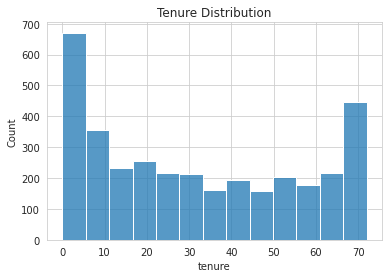

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=sample_data, x='tenure')
plt.title('Tenure Distribution')
plt.show()

<div style="width:640px;font-size:16px;background-color:WhiteSmoke;padding:15px">

We can examine feature differences in the distribution of our features when we condition (split) our data.
We'll use [seaborn's BoxPlot function](https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot) for this, 
though we could have also use many other functions or entirely different packages.

<div>

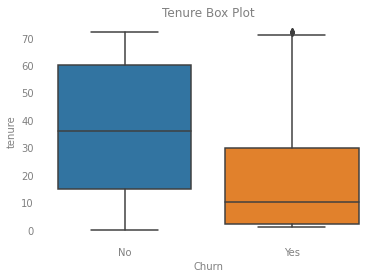

In [21]:
plt.grid(b=None)
plt.title("Tenure Box Plot",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel("",color='grey')
plt.ylabel("",color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.boxplot(x="Churn", y="tenure", data=sample_data);

In these examples, we only examined one column,
but a complete analysis would examine all the rest for data quality issues or potentially useful or useless features.

## Joint Distributions
Looking at joint distributions of data can also tell us a lot, particularly about duplicated features that need removing.
[Seaborn's PairPlot](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) is a quick way to look at joint distributions for many variables at once.
Note that it may struggle with a large number of columns, so we demonstrate with three.

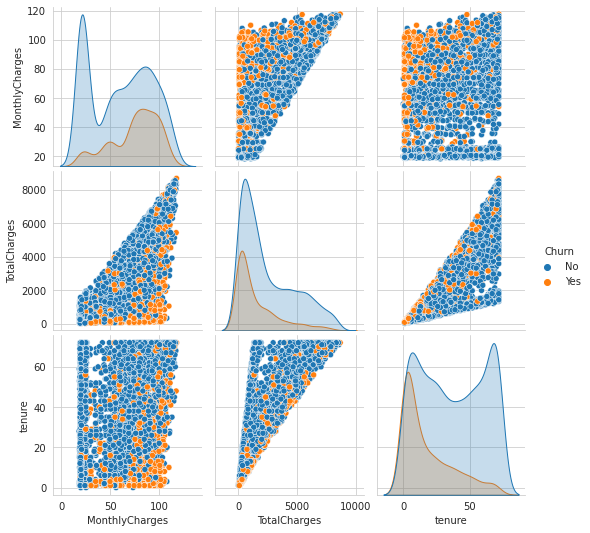

In [22]:
sns.set_style("whitegrid")
example_numeric_data = sample_data[["MonthlyCharges", "TotalCharges","tenure","Churn"]]  # pick a few columns
sns.pairplot(example_numeric_data, hue="Churn");

## Stop the Spark session
Jupyter Notebooks take longer to timeout than regular workbench sessions, so its good practice to add a `spark.stop()` call in you notebook to make sure any spark resources are added back to the cluster if you aren't using them.

In [23]:
spark.stop()

## Wrap up
We've now covered a quick **exploratory data analysis** using Spark SQL, Spark DataFrames, and seaborn.
We've also explained how to **install packages** in a CML Project.
This is just a taste, and you can install any of your favorite packages—even custom ones—to dig even further.

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***